<a href="https://colab.research.google.com/github/Hydra-Slayer/Image-encryption-using-Chaotic-Map/blob/main/Project1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import dependencies
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def map(x0, R):
    """ Define a function called 'map' which returns the value of x1 for a given x0 and R. """
    # return R * x0 * (1 - x0)
    return np.mod(R * x0 * (1 - x0) * 2**12, 1)

def orbit(x0, R, maxiter):
    """ Define a function that returns an orbit, that is, the values of x1, x2, ..., xn starting from a given x0 and R. """
    # Initialize a list and set the first element to x0
    x = [x0]
    # Generate the full map values
    for n in range(maxiter):
        x.append(map(x[-1], R))
    return x

# Add index and sort by the second value in each tuple
def add_index_to_map(map_matrix):
  '''Adds a index to the map matrix and returns the sorted map index values only'''
  enumerated_x = list(enumerate(x))
  # print(enumerated_x)
  enumerated_x.sort(key=lambda x: x[1])
  indexes = [index for index, _ in enumerated_x]
  return indexes

def show_image(image_path):
  # Load the image and convert to grayscale
    image = Image.open(image_path).convert('L')
    # Convert the image to a numpy array (grayscale)
    image_matrix = np.array(image)
    plt.imshow(image_matrix, cmap='gray')
    plt.axis('off')  # Turn off axis labels
    plt.show()

def flatten_image(image_path):
    """
    Flatten a grayscale image into a 1D array.

    Parameters:
    - image_path: Path to the input grayscale image.

    Returns:
    - flattened_image: Flattened 1D array of pixel values.
    - original_shape: Tuple containing the original shape of the image (for reshaping after operations).
    """
    # Load the image and convert to grayscale
    image = Image.open(image_path).convert('L')

    # Convert the image to a numpy array (grayscale)
    image_matrix = np.array(image)

    # Get the original shape of the image
    original_shape = image_matrix.shape

    # Flatten the 2D image matrix into a 1D array
    flattened_image = image_matrix.flatten()

    return flattened_image, original_shape


#encrypt fucntion
def scramble(image_path, chaotic_map_indices, output_path):
    """
    Scrambles a grayscale image based on chaotic map indices.

    Parameters:
    - image_path: Path to the input grayscale image.
    - chaotic_map_indices: List of indices generated by the chaotic map for scrambling.
    - output_path: Path to save the scrambled image.
    """

    flattened_image,orignal_shape = flatten_image(image_path)

    # Reorder the flattened image according to the chaotic map indices
    scrambled_image = np.array([flattened_image[i] for i in chaotic_map_indices])

    # Reshape the scrambled list back into the original 2D image shape
    scrambled_matrix = scrambled_image.reshape(orignal_shape)

    # Convert the scrambled matrix back to an image
    scrambled_image = Image.fromarray(np.uint8(scrambled_matrix))

    # Save the scrambled image
    scrambled_image.save(output_path)

    print(f"Scrambling complete. File saved at {output_path}")
    show_image('scrambled_image.png')


## generates a key stream from the chaotic map
# def generate_key_stream_from_chaos(image_shape, x0, R, maxiter):
#     """
#     Generates a key stream based on chaotic map values.

#     Parameters:
#     - image_shape: Tuple representing the shape of the image (height, width).
#     - x0: Initial value for chaotic map.
#     - R: Control parameter for chaotic map.
#     - maxiter: Number of iterations for the chaotic map.

#     Returns:
#     - key_stream: 2D numpy array of the same shape as the image, containing the key stream.
#     """
#     # Generate chaotic map values
#     x = orbit(x0, R, maxiter)

#     # Scale chaotic values to the 0-255 range
#     x_scaled = np.array(x[:np.prod(image_shape)]) * 255

#     # Ensure values are within the 0-255 range
#     x_scaled = np.clip(x_scaled, 0, 255)

#     # Reshape to match image shape
#     key_stream = x_scaled.reshape(image_shape).astype(np.uint8)

#     return key_stream


def generate_key_stream_from_chaos(image_shape, x0, R, maxiter):
    """
    Generates a key stream based on chaotic map values scaled by a large number.

    Parameters:
    - image_shape: Tuple representing the shape of the image (height, width).
    - x0: Initial value for chaotic map.
    - R: Control parameter for chaotic map.
    - maxiter: Number of iterations for the chaotic map.
    - large_number: Large number to scale chaotic map values.

    Returns:
    - key_stream: 2D numpy array of the same shape as the image, containing the key stream.
    """
    # Generate chaotic map values
    x = orbit(x0, R, maxiter)

    # Scale chaotic values by a large number
    x_scaled = np.array(x[:np.prod(image_shape)]) * (2**9)

    # Reduce to 0-255 range using modulo operation
    key_stream = np.mod(x_scaled, 256)

    # Reshape to match image shape and ensure values are uint8
    key_stream = key_stream.reshape(image_shape).astype(np.uint8)
    return key_stream

## xor image values with map values
def xor_with_key(img_path, key_stream, output_img_path):
    """
    Applies XOR operation between the scrambled image matrix and a key stream.

    Parameters:
    - image_matrix: 2D numpy array representing the grayscale scrambled image.
    - key_stream: 1D or 2D numpy array representing the key stream (should match image size).

    Returns:
    - xor_result: 2D numpy array of the XORed image.
    """

    scrambled_image_path = img_path
    scrambled_image = Image.open(scrambled_image_path).convert('L')
    image_matrix = np.array(scrambled_image)
    # Ensure the key_stream is the same shape as the image_matrix
    assert image_matrix.shape == key_stream.shape, "Key stream and image size must match."

    # Apply XOR between each pixel value and the corresponding key stream value
    xor_result = np.bitwise_xor(image_matrix, key_stream)
    # Convert the XORed result back to an image and save or show it
    xor_image = Image.fromarray(xor_result)
    xor_image.save(f"{output_img_path}")
    print("xor operation complete")
    show_image(f"{output_img_path}")



### Set initial parameters
u = 3.8
x0 = 0.5
iterations = 65535

# Generate map values
x = orbit(x0, u, iterations)
indexes = add_index_to_map(x)
img_shape = (256,256)
# print(indexes)

show_image('lena_grayscale.png')

scramble('lena_grayscale.png', indexes, 'scrambled_image.png')







def unscramble(encrypted_image_path, chaotic_map_indices, output_path):
    """
    Decrypts a scrambled grayscale image based on the original chaotic map indices.

    Parameters:
    - encrypted_image_path: Path to the scrambled (encrypted) grayscale image.
    - chaotic_map_indices: List of indices generated by the chaotic map used for scrambling.
    - output_path: Path to save the unscrambled (decrypted) image.
    """

    # Flatten the 2D scrambled matrix into a 1D array
    scrambled_flattened,shape = flatten_image(encrypted_image_path)

    # Initialize an array for the decrypted image (same size as the scrambled_flattened array)
    decrypted_image = np.zeros_like(scrambled_flattened)

    # Reverse the scrambling process by placing the scrambled pixels back to their original positions
    for i, index in enumerate(chaotic_map_indices):
        decrypted_image[index] = scrambled_flattened[i]

    # Reshape the decrypted 1D array back into the original 2D image shape
    decrypted_matrix = decrypted_image.reshape(shape)

    # Convert the decrypted matrix back to an image
    decrypted_image = Image.fromarray(np.uint8(decrypted_matrix))

    # Save the decrypted image
    decrypted_image.save(output_path)

    print(f"Descrambling complete. File saved at {output_path}")
    show_image(f'{output_path}')


keys = generate_key_stream_from_chaos(img_shape, x0, u, iterations)

xor_with_key('scrambled_image.png', keys,'xor_first_time.png')
xor_with_key('xor_first_time.png', keys,'xor_second_time.png')
unscramble('xor_first_time.png', indexes, 'descrambled_image.png')
unscramble('xor_second_time.png', indexes, 'decrypted_unscrambled_image.png')


FileNotFoundError: [Errno 2] No such file or directory: '/content/lena_grayscale.png'

In [ ]:
!pip install pycryptodome

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 18.9 MB/s eta 0:00:00


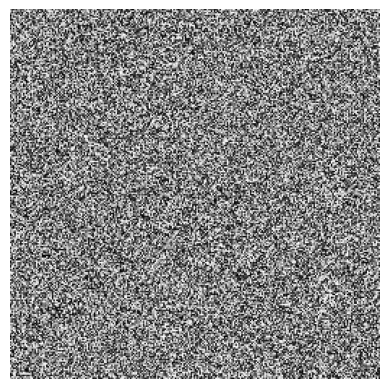

Image encryption complete. Encrypted image saved at aes_encrypted_image.png


In [ ]:
from Crypto.Cipher import AES
from Crypto.Util.Padding import pad
from Crypto.Random import get_random_bytes
import numpy as np
from PIL import Image

def aes_encrypt_image(image_path, key, output_path):
    """
    Encrypts a scrambled grayscale image using AES encryption.

    Parameters:
    - image_path: Path to the scrambled grayscale image.
    - key: AES key for encryption (must be 16 bytes).
    - output_path: Path to save the AES encrypted image.
    """
    # Load the image and convert to grayscale
    image = Image.open(image_path).convert('L')

    # Convert the image to a numpy array (grayscale)
    image_matrix = np.array(image)

    # Flatten the image into a 1D array of bytes
    flattened_image = image_matrix.flatten()

    # Convert the flattened image to bytes
    image_bytes = bytes(flattened_image)

    # Initialize the AES cipher in ECB mode
    cipher = AES.new(key, AES.MODE_ECB)

    # Pad the image bytes to make the length a multiple of the AES block size (16 bytes)
    padded_image_bytes = pad(image_bytes, AES.block_size)

    # Encrypt the padded image bytes
    encrypted_image_bytes = cipher.encrypt(padded_image_bytes)

    # Convert the encrypted bytes back to a numpy array
    encrypted_image = np.frombuffer(encrypted_image_bytes, dtype=np.uint8)

    # Reshape the encrypted array back to the original image dimensions
    encrypted_image_matrix = encrypted_image[:image_matrix.size].reshape(image_matrix.shape)

    # Convert the encrypted matrix back to an image
    encrypted_image = Image.fromarray(encrypted_image_matrix)

    # Save the AES encrypted image
    encrypted_image.save(output_path)
    show_image('aes_encrypted_image.png')
    print(f"Image encryption complete. Encrypted image saved at {output_path}")

# Example usage:
aes_encrypt_image('xor_first_time.png', b'1234567890abcdef', 'aes_encrypted_image.png')


### A Block for Testing new code


In [ ]:
import cv2
import numpy as np

def getSSISM(I1, I2):
    '''
    :param i1: represents original image matrix
    :param i2: represents degraded image matrix
    :return: SSIM score
    '''
    # Constants for luminance and contrast
    C1 = 6.5025
    C2 = 58.5225
    # C3=C2/2

    # converting to float for squaring
    I1 = np.float32(I1)
    I2 = np.float32(I2)
    I2_2 = I2 * I2
    I1_2 = I1 * I1
    I1_I2 = I1 * I2

    # applying GaussianBlur with (11,11) kernel where mean=st_dev=1.5
    mu1 = cv2.GaussianBlur(I1, (11, 11), 1.5)
    mu2 = cv2.GaussianBlur(I2, (11, 11), 1.5)
    mu1_2 = mu1 * mu1
    mu2_2 = mu2 * mu2
    mu1_mu2 = mu1 * mu2

    sigma1_2 = cv2.GaussianBlur(I1_2, (11, 11), 1.5)
    sigma1_2 -= mu1_2
    sigma2_2 = cv2.GaussianBlur(I2_2, (11, 11), 1.5)
    sigma2_2 -= mu2_2
    sigma12 = cv2.GaussianBlur(I1_I2, (11, 11), 1.5)
    sigma12 -= mu1_mu2

    t1 = 2 * mu1_mu2 + C1
    t2 = 2 * sigma12 + C2
    t3 = t1 * t2  # t3 = ((2*mu1_mu2 + C1).*(2*sigma12 + C2))
    t1 = mu1_2 + mu2_2 + C1
    t2 = sigma1_2 + sigma2_2 + C2
    t1 = t1 * t2  # t1 =((mu1_2 + mu2_2 + C1).*(sigma1_2 + sigma2_2 + C2))
    ssim_map = cv2.divide(t3, t1)
    ssim = cv2.mean(ssim_map)
    return ssim

image_mat1,shape1 = flatten_image('lena_grayscale.png')
image_mat3,shape3 = flatten_image('aes_encrypted_image.png')
image_mat2,shape2 = flatten_image('xor_first_time.png')
print(getSSISM(image_mat1,image_mat2))
print(getSSISM(image_mat1,image_mat3))

(0.017181318390869907, 0.0, 0.0, 0.0)
(0.012972418071275228, 0.0, 0.0, 0.0)


In [ ]:
import cv2
import numpy as np

def getPSNR(I1, I2):
    '''
    :param I1: represents original image matrix
    :param I2: represents degraded image matrix
    :return: psnr score
    '''
    # mse calculation
    s1 = cv2.absdiff(I1, I2)
    # cannot make a square on 8 bits
    s1 = np.float32(s1)
    s1 = s1 * s1
    sse = s1.sum()

    # return zero if the difference is extremely small
    if sse <= 1e-10:
        return 0
    else:
        # Handle grayscale or color images
        shape = I1.shape

        mse = sse / (255 * 255)


        # Here 255 denotes the maximum possible value in an 8-bit channel
        psnr = 10.0 * np.log10((255 * 255) / mse)
        return psnr

# Load and compare images
image_mat1, shape1 = flatten_image('lena_grayscale.png')
image_mat2, shape2 = flatten_image('aes_encrypted_image.png')

# Compute PSNR
print(getPSNR(image_mat1, image_mat2))

9.180897642334077


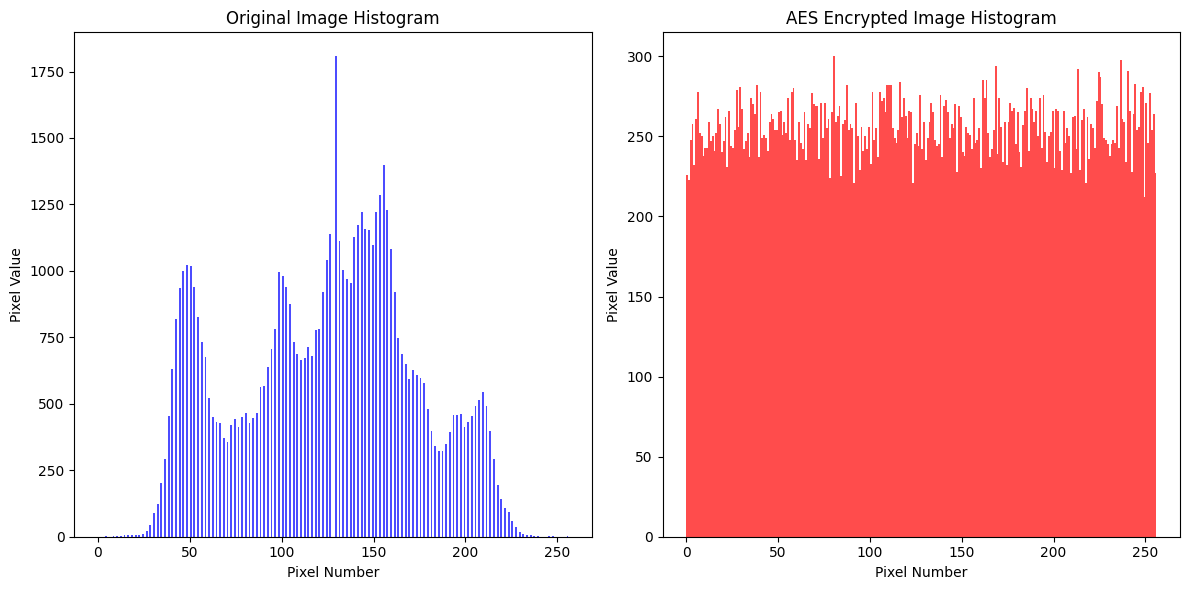

In [ ]:
def plot_histograms(original_image_path, encrypted_image_path):
    """
    Plots the histograms of the original and AES-encrypted grayscale images.

    Parameters:
    - original_image_path: Path to the original grayscale image.
    - encrypted_image_path: Path to the AES-encrypted grayscale image.
    """
    # Load the original image and convert to grayscale
    original_image = Image.open(original_image_path).convert('L')
    original_image_array = np.array(original_image)

    # Load the encrypted image and convert to grayscale
    encrypted_image = Image.open(encrypted_image_path).convert('L')
    encrypted_image_array = np.array(encrypted_image)

    # Plot histograms
    plt.figure(figsize=(12, 6))

    # Original image histogram
    plt.subplot(1, 2, 1)
    plt.hist(original_image_array.flatten(), bins=256, range=(0, 256), color='blue', alpha=0.7)
    plt.title('Original Image Histogram')
    plt.xlabel('Pixel Number')
    plt.ylabel('Pixel Value')

    # Encrypted image histogram
    plt.subplot(1, 2, 2)
    plt.hist(encrypted_image_array.flatten(), bins=256, range=(0, 256), color='red', alpha=0.7)
    plt.title('AES Encrypted Image Histogram')
    plt.xlabel('Pixel Number')
    plt.ylabel('Pixel Value')

    # Show the histograms
    plt.tight_layout()
    plt.show()

# Example usage
plot_histograms('lena_grayscale.png', 'aes_encrypted_image.png')

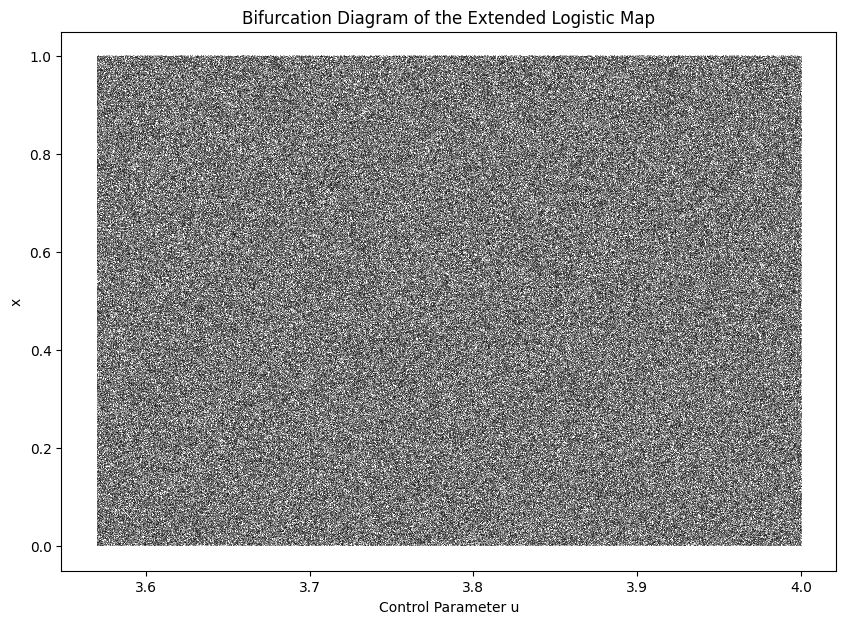

In [ ]:
def bifurcation_diagram_extended(r_min, r_max, num_r, iterations, last):
    """
    Plots the bifurcation diagram for the extended logistic map.

    Parameters:
    - r_min: Minimum value of the control parameter u.
    - r_max: Maximum value of the control parameter u.
    - num_r: Number of u values to sample.
    - iterations: Number of iterations for each u value.
    - last: Number of points to plot after the transient behavior.
    """
    r_values = np.linspace(r_min, r_max, num_r)
    x = 1e-5 * np.ones(num_r)  # Initial condition

    plt.figure(figsize=(10, 7))

    for i in range(iterations):
        x = extended_logistic_map(x, r_values)
        if i >= (iterations - last):
            plt.plot(r_values, x, ',k', alpha=0.25)  # Plot the stable points

    plt.title("Bifurcation Diagram of the Extended Logistic Map")
    plt.xlabel("Control Parameter u")
    plt.ylabel("x")
    plt.show()

# Parameters for the bifurcation diagram
r_min = 3.57  # Starting value of u
r_max = 4.0   # Ending value of u
num_r = 10000 # Number of u values to sample
iterations = 1000  # Total number of iterations
last = 100  # Number of points to plot after the transient behavior


# Generate the bifurcation diagram for the extended logistic map
bifurcation_diagram_extended(r_min, r_max, num_r, iterations, last)

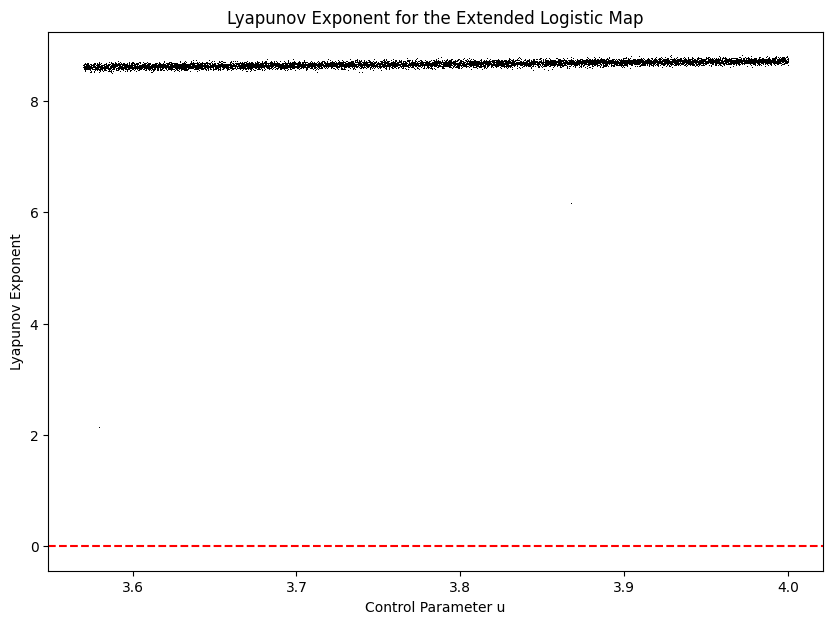

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def extended_logistic_map(x, u):
    """
    Extended logistic map function with a factor of 2^12 and modulo 1 operation.

    Parameters:
    - x: Current state.
    - u: Control parameter.

    Returns:
    - Updated state based on the modified logistic map equation.
    """
    return np.mod(u * x * (1 - x) * 2**12, 1)

def logistic_map_derivative(x, u):
    """
    Derivative of the extended logistic map with respect to x.

    Parameters:
    - x: Current state.
    - u: Control parameter.

    Returns:
    - Derivative of the extended logistic map.
    """
    return np.abs(u * (1 - 2 * x) * 2**12)

def lyapunov_exponent(u, iterations=1000, transient=100):
    """
    Calculate the Lyapunov exponent for a given control parameter u.

    Parameters:
    - u: Control parameter.
    - iterations: Number of total iterations.
    - transient: Number of initial iterations to discard (transient behavior).

    Returns:
    - Lyapunov exponent for the given control parameter u.
    """
    x = 1e-5  # Initial condition
    lyapunov_sum = 0

    for i in range(iterations):
        x = extended_logistic_map(x, u)
        if i >= transient:  # Ignore transient iterations
            derivative = logistic_map_derivative(x, u)
            if derivative == 0:
                derivative = 1e-10  # To avoid log(0) errors
            lyapunov_sum += np.log(derivative)

    # Average over iterations to get the exponent
    return lyapunov_sum / (iterations - transient)

def plot_lyapunov_exponent(r_min, r_max, num_r, iterations=1000, transient=100):
    """
    Plot the Lyapunov exponent as a function of the control parameter u.

    Parameters:
    - r_min: Minimum value of the control parameter u.
    - r_max: Maximum value of the control parameter u.
    - num_r: Number of u values to sample.
    - iterations: Number of total iterations for each u value.
    - transient: Number of initial iterations to discard.
    """
    r_values = np.linspace(r_min, r_max, num_r)
    lyapunov_values = []

    for u in r_values:
        lyapunov_values.append(lyapunov_exponent(u, iterations, transient))

    plt.figure(figsize=(10, 7))
    plt.plot(r_values, lyapunov_values, ',k')
    plt.axhline(0, color='r', linestyle='--')  # Reference line for chaos (Lyapunov > 0)
    plt.title("Lyapunov Exponent for the Extended Logistic Map")
    plt.xlabel("Control Parameter u")
    plt.ylabel("Lyapunov Exponent")
    plt.show()

# Parameters for Lyapunov exponent plot
r_min = 3.57  # Starting value of u
r_max = 4.0   # Ending value of u
num_r = 10000 # Number of u values to sample
iterations = 1000  # Total number of iterations
transient = 100  # Transient iterations to discard

# Plot the Lyapunov exponent for the extended logistic map
plot_lyapunov_exponent(r_min, r_max, num_r, iterations, transient)
